In [4]:
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

In [5]:
#importing crossections
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("../../data/atmosphere/xsecs")
CIACache().set_cia_path("../../data/atmosphere/cia/hitran")


***Building Model***

In [22]:
#(parameters: https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39%20b#planet_WASP-39-b_collapsible)
#Atmospheric model
#guillot
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1166.0) #?????

#isthermal
from taurex.temperature import Isothermal
isothermal = Isothermal(T=1166.0) #Teq

#Planet
from taurex.planet import Planet
planet = Planet(planet_radius=1.27,planet_mass=0.275)

#star
from taurex.stellar import BlackbodyStar
from taurex.stellar import PhoenixStar
star = BlackbodyStar(temperature=5400.0,radius=0.895) #ideal blackbody
anotherstar = PhoenixStar(phoenix_path='../../data/atmosphere/phoenix/BT-Settl_M-0.0a+0.0',
                          temperature=5400.0,radius=0.895) #considering stellar atmosphere

#chemistry
#Main components
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

#others

# Set a random seed for reproducibility
np.random.seed(45)

# Create random values for the abbundances
basis = np.round(np.random.uniform(0, 10, 4),3)  # 4 random numbers between 0 and 10
exponent = -np.random.randint(2, 9, 4)   # 4 random integers between 2 and 8 (inclusive)

mix_ratio = [basis[0]*10.0**(exponent[3]),basis[1]*10.0**(exponent[2]),basis[2]*10.0**(exponent[1]),basis[3]*10.0**(exponent[0])]

print('*************************\n'
    f'Random mixing ratios:\n'
      f'H2O: {mix_ratio[0]}\n'
      f'CH4: {mix_ratio[1]}\n'
      f'CO2: {mix_ratio[2]}\n'
      f'CO: {mix_ratio[3]}\n'
      '*************************')

from taurex.chemistry import ConstantGas
h2o = ConstantGas('H2O',mix_ratio=mix_ratio[0])
chemistry.addGas(h2o)
ch4 = ConstantGas('CH4',mix_ratio=mix_ratio[1])
chemistry.addGas(ch4)
co2 = ConstantGas('CO2',mix_ratio=mix_ratio[2])
chemistry.addGas(co2)
co = ConstantGas('CO',mix_ratio=mix_ratio[3])
chemistry.addGas(co)

#all toghether
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=anotherstar,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

*************************
Random mixing ratios:
H2O: 0.0989
CH4: 0.005495
CO2: 2.814e-06
CO: 7.73e-06
*************************


In [23]:
 
#physical phenomena
#absorption
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

#CIA (collisional induced absorption)
from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

#scattering
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()

In [24]:
#running the model
res = tm.model()

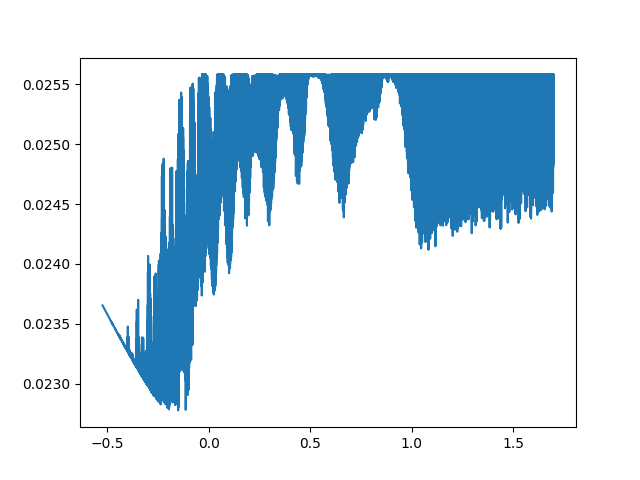

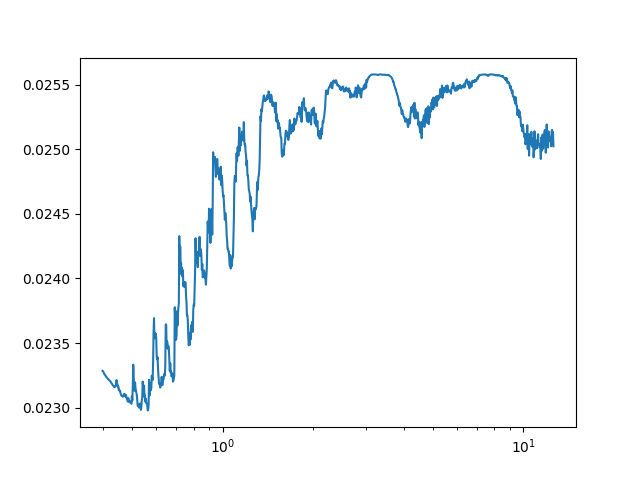

In [26]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()